## Exploratory Data Analysis on Seattle Terry Stops
This is a continuation of the project we started by preprocessing. As stated in the first part of this project, the "Preprocess file", the objectives of this project are:

* Determine if there is a relationship between Terry Stops and a subject's race
* Do the differences in races between the officer and the subject play a role in arrests?
* How do Terry Stops in Seattle compare to the circumstances around *Terry v. Ohio*?
* Determine the likelihood of an arrest occurring during a Terry Stop

In this part we will address the first three objectives and the fourth one will be covered in the third part of this project which is the modeling part.

## Loading the cleaned data

In [2]:
# Importing the relevant libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('data/clean_Terry_stops_data.csv')
# df = df.drop('Unnamed:0', axis=1)
df.head()


,subject_age_group,subject_id,go_sc_num,terry_stop_id,stop_resolution,weapon_type,officer_id,officer_gender,officer_race,subject_perceived_race,...,beat,repeat_offenders,incident_year,incident_month,officer_age,field_contact,offense_report,reported_hour,same_race,same_gender
0,36_45,unassigned,20160000398323,208373,Offense Report,NaN,4852,M,Asian,White,...,L3,No,2016,11,63,N,Y,15,N,Y
1,18_25,unassigned,20180000227180,559146,Citation / Infraction,NaN,5472,M,Asian,Hispanic,...,F3,No,2018,6,54,N,N,0,N,Y
2,18_25,unassigned,20180000410091,498246,Offense Report,NaN,6081,M,White,White,...,B1,No,2018,11,56,N,Y,2,Y,Y
3,Unknown,unassigned,20160000001637,146742,Field Contact,NaN,6924,M,White,Not Specified,...,C1,No,2016,4,42,Y,N,1,N,N
4,46_55,unassigned,20150000006037,104477,Field Contact,NaN,6732,M,White,White,...,B2,No,2015,11,40,Y,N,2,Y,N


## Relationship between Terry Stops and Subject's Race
Here we will try to see if there is any relationship between the Terry Stops and the Subject's Race.

In [4]:
# Let us first check the stop resolutions
df.stop_resolution.value_counts()

stop_resolution
Field Contact               29173
Offense Report              15555
Arrest                      14592
Referred for Prosecution      717
Citation / Infraction         215
Name: count, dtype: int64

We are trying to see if race has any role to play in the Terry Stops. To do that let us calculate what the stop ratios are for each race in the dataset.

In [5]:
# Checking the races in the dataset
df.subject_perceived_race.value_counts()

subject_perceived_race
White                        29548
Black or African American    18119
Not Specified                 6108
Asian                         2070
Hispanic                      1666
Native American               1638
Multi-Racial                   796
Other                          307
Name: count, dtype: int64

In [6]:
# Values for each race in the dataset
White = 29548
African_American = 18119
Not_Specified = 6108
Asian = 2070
Hispanic = 1666
Native_American = 1638
Multi_Racial = 796
Other = 307

# Calculating the stop ratios for each race
stop_ratio_white = White / len(df['stop_resolution'])
stop_ratio_African_American = African_American / len(df['stop_resolution'])
stop_ratio_Not_Specified = Not_Specified / len(df['stop_resolution'])
stop_ratio_Asian = Asian / len(df['stop_resolution'])
stop_ratio_Hispanic = Hispanic / len(df['stop_resolution'])
stop_ratio_Native_American = Native_American / len(df['stop_resolution'])
stop_ratio_Multi_Racial = Multi_Racial / len(df['stop_resolution'])
stop_ratio_Other = Other / len(df['stop_resolution'])

# Creating a dataframe to display the stop ratios
keys = ['White', 'African American', 'Not Specified', 'Asian', 
        'Hispanic', 'Native American', 'Multi-Racial', 'Other']
vals = [stop_ratio_white, stop_ratio_African_American, stop_ratio_Not_Specified, 
        stop_ratio_Asian, stop_ratio_Hispanic, stop_ratio_Native_American, stop_ratio_Multi_Racial, stop_ratio_Other]

ratio = {}

for key in keys:
    for val in vals:
        ratio[key] = val
        vals.remove(val)
        break


stop_ratio_df = pd.DataFrame(ratio, index=[0])
stop_ratio_df


,White,African American,Not Specified,Asian,Hispanic,Native American,Multi-Racial,Other
0,0.490407,0.30072,0.101374,0.034356,0.027651,0.027186,0.013211,0.005095


Ok so we see here that the highest stop ratio is for White with 49% and African American follows second with 30%.

Text(0.5, 1.0, 'Proportion of People Stopped According to Respective Population')

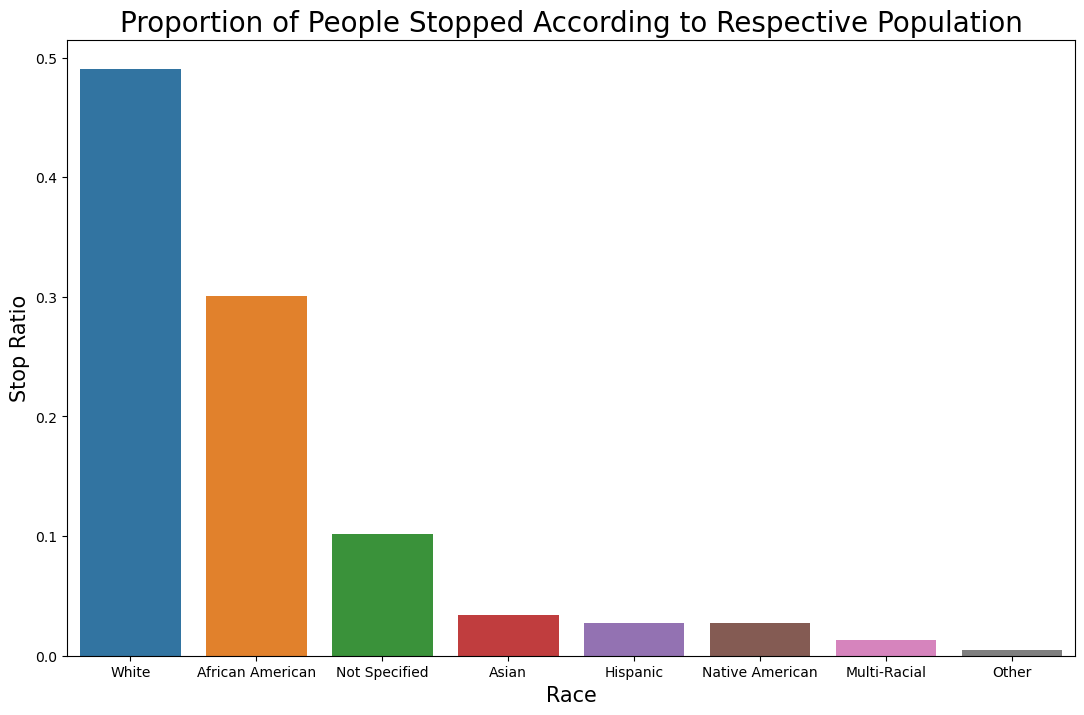

In [7]:
# let us plot this ratios
fig = plt.figure(figsize=(13,8))

ax = sns.barplot(stop_ratio_df)

ax.set_xlabel('Race', fontsize=15)
ax.set_ylabel('Stop Ratio', fontsize=15), 
ax.set_title('Proportion of People Stopped According' + ' to Respective Population', fontsize=20)


Ok this bar plot shows the same findings as the above function. The other races however have unbelievably low instances. This requires to be checked. Let us do the frisk flag test to see what happens.

In [8]:
# Let create a dataframe called frisked to see the racial distributions of the frisk flag
frisked = df.copy()
frisked = frisked[frisked['frisk_flag'] == 'Y']

frisked.subject_perceived_race.value_counts()

subject_perceived_race
White                        6100
Black or African American    5142
Not Specified                1566
Asian                         572
Hispanic                      435
Native American               385
Multi-Racial                  181
Other                          74
Name: count, dtype: int64

In [9]:
# Frisk ratio per race
frisk_ratio_white = White / len(frisked['subject_perceived_race'])
frisk_ratio_African_American = African_American / len(frisked['subject_perceived_race'])
frisk_ratio_Not_Specified = Not_Specified / len(frisked['subject_perceived_race'])
frisk_ratio_Asian = Asian / len(frisked['subject_perceived_race'])
frisk_ratio_Hispanic = Hispanic / len(frisked['subject_perceived_race'])
frisk_ratio_Native_American = Native_American / len(frisked['subject_perceived_race'])
frisk_ratio_Other = Other / len(frisked['subject_perceived_race'])
frisk_ratio_Multi_Racial = Multi_Racial / len(frisked['subject_perceived_race'])

keys = ['White', 'African_American', 'Not_Specified', 'Asian', 'Hispanic', 'Native_American', 'Other', 'Multi_Racial']
vals = [frisk_ratio_white, frisk_ratio_African_American, frisk_ratio_Not_Specified, frisk_ratio_Asian, frisk_ratio_Hispanic, 
        frisk_ratio_Native_American, frisk_ratio_Other, frisk_ratio_Multi_Racial]

frisk_ratio = {}

for key in keys:
    for val in vals:
        frisk_ratio[key] = val
        vals.remove(val)
        break

frisked_ratio_df = pd.DataFrame(frisk_ratio, index=[0])
frisked_ratio_df

,White,African_American,Not_Specified,Asian,Hispanic,Native_American,Other,Multi_Racial
0,2.044137,1.253476,0.422553,0.143203,0.115254,0.113317,0.021238,0.055067


Text(0.5, 1.0, 'Number of People Frisked VS Race')

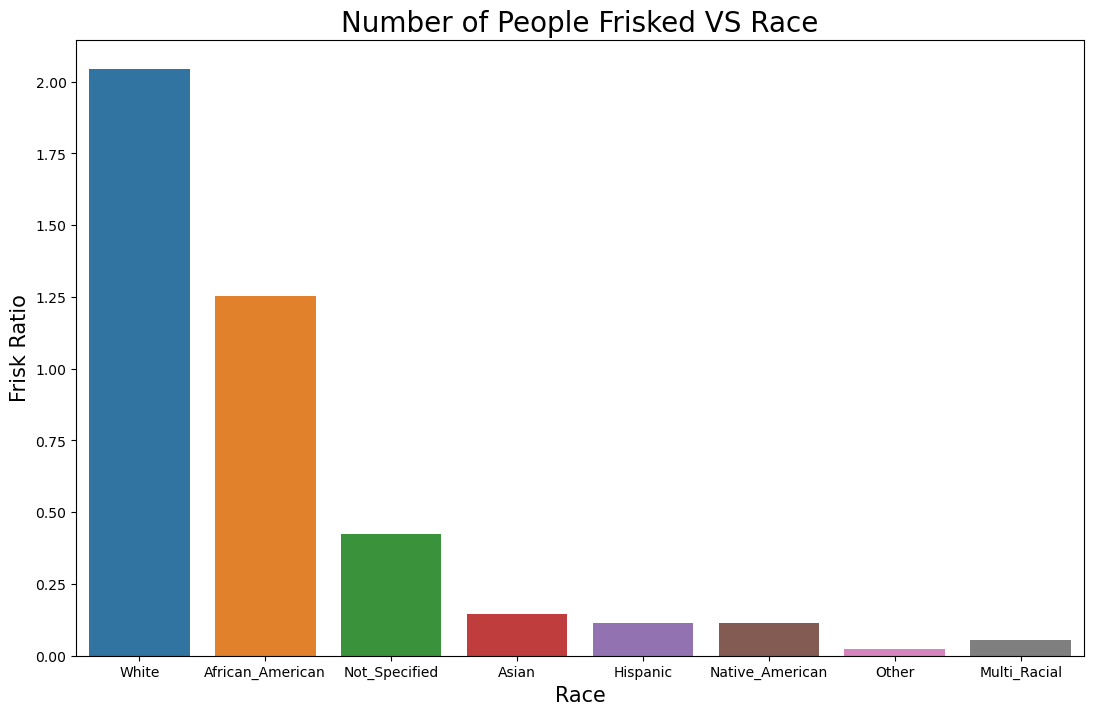

In [10]:
# Let us plot the frisk ratio
fig = plt.figure(figsize=(13,8))

ax = sns.barplot(frisked_ratio_df)

ax.set_xlabel('Race', fontsize=15)
ax.set_ylabel('Frisk Ratio', fontsize=15),
ax.set_title('Number of People Frisked VS' + ' Race', fontsize=20)

It appears that of all the stop instances there are very few instances of frisking but still the whites appear to be the more frisked of all the other races followed by African-Americans. Let us try another analysis that deals with the arrests and see if the arrests are racially influenced.

In [12]:
# Mapping the values of dif_race to 'Y' and 'N'
# df['same_race'] = df['same_race'].map({True: 'Y', False: 'N'})

# Relationship between Terry Stops and Arrests
arrests = df[['arrest_flag', 'frisk_flag', 'same_race']]

print(arrests.shape)
arrests.head()


(60252, 3)


,arrest_flag,frisk_flag,same_race
0,N,N,N
1,N,N,N
2,N,N,Y
3,N,N,N
4,N,N,Y


Ok now we'll make 2 datasets: One where officer and subject are the same race and another where they are not.

In [13]:
# Making datasets with the same officer and subject race and different officer and subject race
same_race = arrests[arrests['same_race'] == 'Y']
diff_race = arrests[arrests['same_race'] == 'N']

print(same_race.shape)
print(diff_race.shape)

(22989, 3)
(37263, 3)


Now lets separate our data into categories we can compare: Same Race Arrests and Frisks & Different Race Arrests and Frisks

In [14]:
same_arrest = 0
same_frisk = 0
for i in range(len(same_race)):
    if same_race.arrest_flag.iloc[i] == 'Y':
        same_arrest += 1
    if same_race.frisk_flag.iloc[i] == 'Y':
        same_frisk += 1
print(f'Same Race: Arrests = {same_arrest}, Frisk Searches = {same_frisk}')

diff_arrest = 0
diff_frisk = 0

for i in range(len(same_race)):
    if diff_race.arrest_flag.iloc[i] == 'Y':
        diff_arrest += 1
    if diff_race.frisk_flag.iloc[i] == 'Y':
        diff_frisk += 1
print(f'Different Race: Arrests = {diff_arrest}, Frisk Searches = {diff_frisk}')

Same Race: Arrests = 2251, Frisk Searches = 4764
Different Race: Arrests = 2649, Frisk Searches = 5967


Since these are based on different sized sets, we'll do what we did with races and calculate the ratio of these values to their respective dataset sizes

In [15]:
# Calculating the ratio
arrest_same_ratio = same_arrest/len(same_race)
frisk_same_ratio = same_frisk/len(same_race)
arrest_diff_ratio = diff_arrest/len(diff_race)
frisk_diff_ratio = diff_frisk/len(diff_race)

# Creating a dataframe for same race arrests and same race frisks
keys = ['Same Race: Arrests', 'Same Race: Frisk Searches']
vals = [arrest_same_ratio, frisk_same_ratio]

same_race = {}

for key in keys:
    for val in vals:
        same_race[key] = val
        vals.remove(val)
        break


same_race_df = pd.DataFrame(same_race, index=[0])
same_race_df 

,Same Race: Arrests,Same Race: Frisk Searches
0,0.097916,0.20723


In [ ]:
# Creating a dataframe for different race arrests and different race frisks
keys = ['Different Race: Arrests', 'Different Race: Frisk Searches']
vals = [arrest_diff_ratio, frisk_diff_ratio]

diff_race = {}

for key in keys:
    for val in vals:
        diff_race[key] = val
        vals.remove(val)
        break

diff_race_df = pd.DataFrame(diff_race, index=[0])
diff_race_df 

,Different Race: Arrests,Different Race: Frisk Searches
0,0.01951,0.147492


In [ ]:
# Combining the two dataframes
race_relations = pd.concat([same_race_df, diff_race_df], axis=1)
race_relations


,Same Race: Arrests,Same Race: Frisk Searches,Different Race: Arrests,Different Race: Frisk Searches
0,0.097916,0.20723,0.01951,0.147492


Text(0.5, 1.0, 'Officer & Subject Treatment: Same Race v. Different Race')

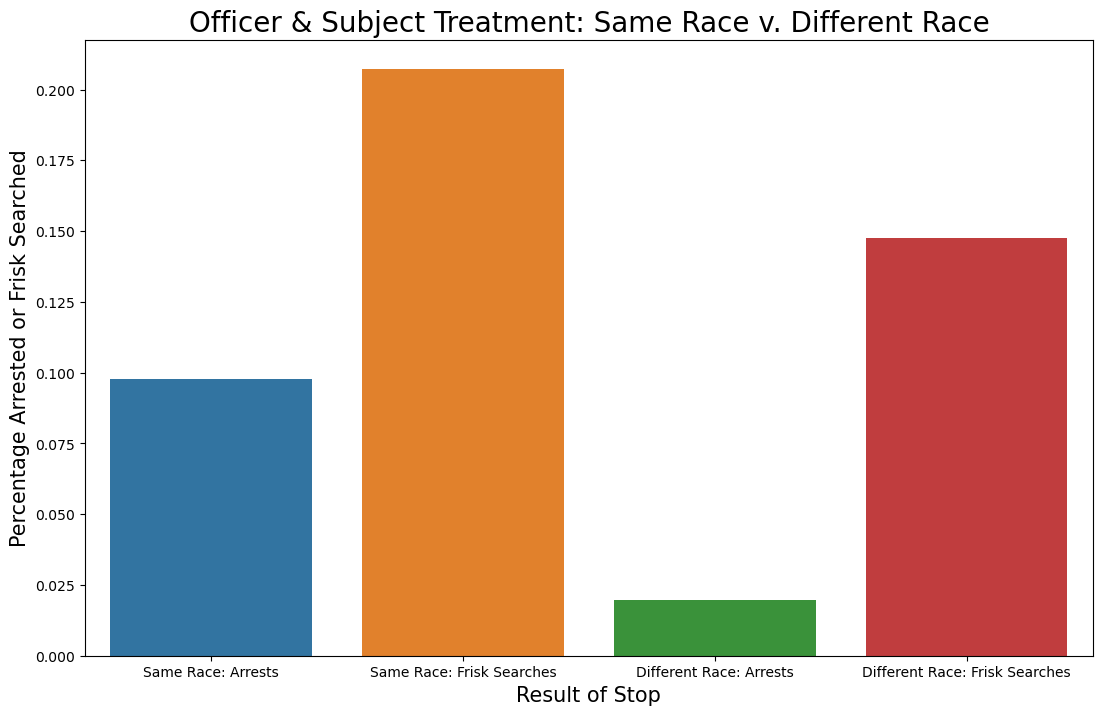

In [ ]:
# Now let's plot this data
fig = plt.figure(figsize=(13,8))

ax = sns.barplot(race_relations)

ax.set_xlabel('Result of Stop', fontsize=15)
ax.set_ylabel('Percentage Arrested or Frisk Searched', fontsize=15),
ax.set_title('Officer & Subject Treatment: '+ 'Same Race v. Different Race', fontsize=20)


Ok so we see that there are more frisks and arrests in the same race, but fewer in different race. There could be a couple of reasons for this.  One is that an officer whose race is different is more hesitant and doesn't want to risk the possibility of their actions being considered racist.  Another explanation is that the officers in Seattle are assigned to beats where the local demographics match their own.  Either way, assuming that these arrests and frisk searches were warranted, it's good to see that the enforcement of the law is roughly equal.

Let us do a comparison between the number of frisks and the number of arrests.

In [ ]:
# Creating a subset of the dataset with the arrest and frisk features
arst_frsk = df[['arrest_flag', 'frisk_flag']]
print(arst_frsk.arrest_flag.value_counts())
print(arst_frsk.frisk_flag.value_counts())

arrest_flag
N    53752
Y     6500
Name: count, dtype: int64
frisk_flag
N    45797
Y    14455
Name: count, dtype: int64


Text(0.5, 1.0, 'Number of Terry Stop Arrests and/or Frisks')

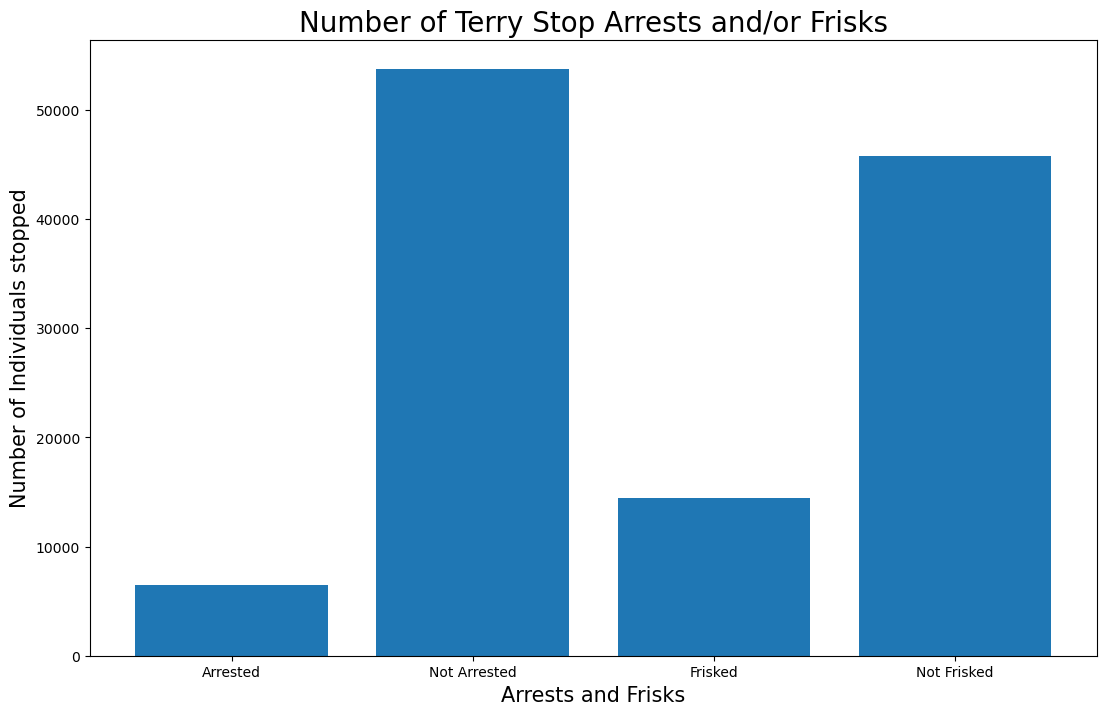

In [ ]:
# Plotting the comparison
arrest_yes = 6500
arrest_no = 53752
frisk_yes = 14455
frisk_no = 45797

x = ['Arrested', 'Not Arrested', 'Frisked', 'Not Frisked']
y = [arrest_yes, arrest_no, frisk_yes, frisk_no]

fig = plt.figure(figsize=(13,8))

ax = sns.barplot()
ax.bar(x, y)
ax.set_xlabel('Arrests and Frisks', fontsize=15)
ax.set_ylabel('Number of Individuals stopped', fontsize=15),
ax.set_title('Number of Terry Stop Arrests and/or Frisks', fontsize=20)



It is interesting to see that there is a huge gap between the number of people frisked and the number of people arrested. This could sound like a faulty call by the officers frisking people without enough information which would mean violation of people's 4th amendment right. On the other hand it could mean a cautious approach by officers, focusing on immediate safety concerns without escalating to arrests unless justified. However, it's important to continuously review these practices to ensure they align with legal standards and community expectations.

To help us decide which one it is in this context, it is good to identify the common outcome of the stop resolutions.

Text(0.5, 1.0, 'Seattle Terry Stop Results')

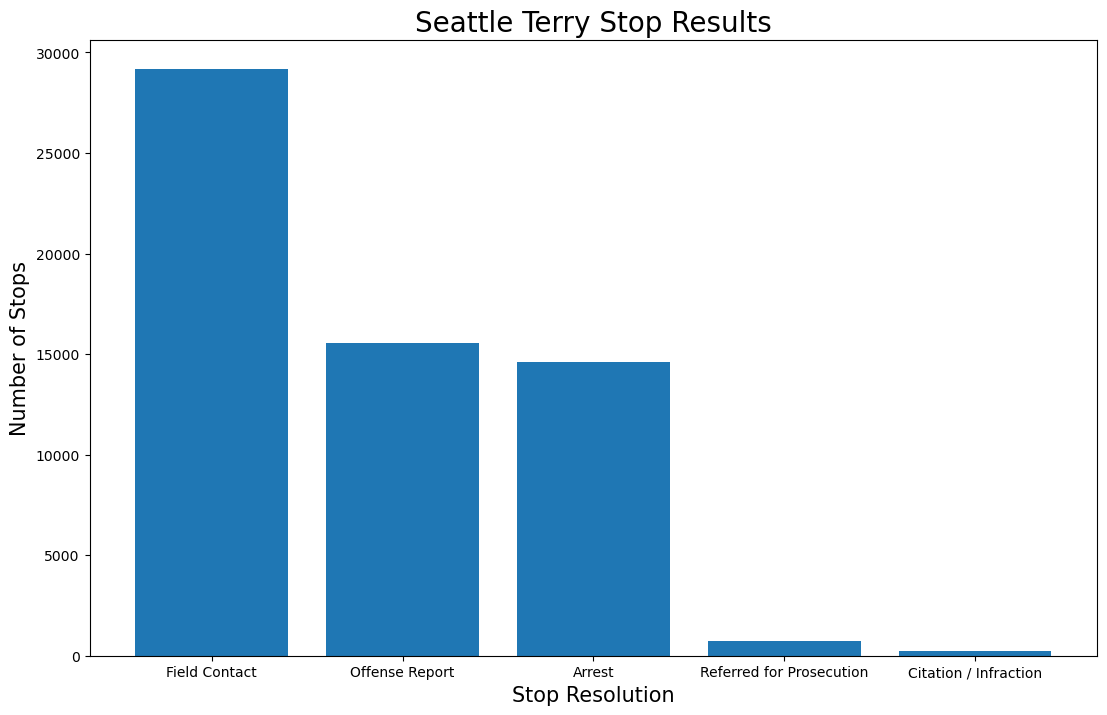

In [ ]:
# Creating a comparison between the different values of the stop resolution
x = df['stop_resolution'].value_counts().index
y = df['stop_resolution'].value_counts()

# Plotting the comparison
fig = plt.figure(figsize=(13,8))

ax = sns.barplot()
ax.bar(x, y)
ax.set_xlabel('Stop Resolution', fontsize=15)
ax.set_ylabel('Number of Stops', fontsize=15)
ax.set_title('Seattle Terry Stop Results', fontsize=20)

The most common outcome of the Seattle Terry Stop resolution happens to be "Field Contact". While field contacts are generally less intrusive than formal stops, a high frequency should be assessed to ensure it aligns with the goals of the resolution, maintains community trust, and is in line with fair policing practices.
This result confirms that the numerous frisk instances are actually more of a preventive measures than violations of people's rights but extreme caution is necessary.